In [61]:
from pathlib import Path
import random
from typing import Dict, List, Union

from cloudpathlib import S3Path
import geopandas as gpd
import pandas as pd
import rasterio

#MAIAC imports
import os
import re

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC, SDS
import pyproj

#alignment import
from pyproj import CRS, Proj

#other imports
from pqdm.processes import pqdm

#raster transforms imports
from rasterio.transform import Affine
from rasterio.warp import reproject, Resampling

#model imports
from sklearn.ensemble import RandomForestRegressor

#MAIAC line
mpl.rcParams['figure.dpi'] = 100

#data lines
DATA_PATH = Path.cwd() / "data"
RAW = DATA_PATH / "raw"
INTERIM = DATA_PATH / "interim"

print(DATA_PATH)
print(RAW)
print(INTERIM)

C:\Users\Skyler\data
C:\Users\Skyler\data\raw
C:\Users\Skyler\data\interim


In [2]:
pm_md = pd.read_csv(
    RAW / "pm25_satellite_metadata.csv",
    parse_dates=["time_start", "time_end"],
    index_col=0
)

grid_md = pd.read_csv(
    RAW / "grid_metadata.csv",
    index_col=0
)
print(pm_md)
print(grid_md)

                                              time_start  \
granule_id                                                 
20180201T191000_maiac_la_0.hdf 2018-02-01 17:25:00+00:00   
20180202T195000_maiac_la_0.hdf 2018-02-02 18:05:00+00:00   
20180203T203000_maiac_la_0.hdf 2018-02-03 17:10:00+00:00   
20180204T194000_maiac_la_0.hdf 2018-02-04 17:55:00+00:00   
20180205T202000_maiac_la_0.hdf 2018-02-05 17:00:00+00:00   
...                                                  ...   
20210721T060842_misr_dl_0.nc   2021-07-21 05:11:48+00:00   
20210730T060258_misr_dl_0.nc   2021-07-30 05:11:45+00:00   
20210806T060933_misr_dl_0.nc   2021-08-06 05:18:20+00:00   
20210815T060400_misr_dl_0.nc   2021-08-15 05:12:45+00:00   
20210822T061044_misr_dl_0.nc   2021-08-22 05:19:30+00:00   

                                                time_end product location  \
granule_id                                                                  
20180201T191000_maiac_la_0.hdf 2018-02-01 19:10:00+00:00   maiac 

In [3]:
pm_md.columns

Index(['time_start', 'time_end', 'product', 'location', 'split', 'us_url',
       'eu_url', 'as_url', 'cksum', 'granule_size'],
      dtype='object')

In [4]:
pm_md["split"].value_counts()

train    5048
test     2673
Name: split, dtype: int64

In [5]:
pm_md["product"].value_counts()

maiac    6704
misr     1017
Name: product, dtype: int64

In [6]:
maiac_md = pm_md[(pm_md["product"] == "maiac") & (pm_md["split"] == "train")].copy()
maiac_md.shape

(4260, 10)

In [7]:
maiac_md.head(3)

,time_start,time_end,product,location,split,us_url,eu_url,as_url,cksum,granule_size
granule_id,,,,,,,,,,
20180201T191000_maiac_la_0.hdf,2018-02-01 17:25:00+00:00,2018-02-01 19:10:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,911405771,10446736
20180202T195000_maiac_la_0.hdf,2018-02-02 18:05:00+00:00,2018-02-02 19:50:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2244451908,11090180
20180203T203000_maiac_la_0.hdf,2018-02-03 17:10:00+00:00,2018-02-03 20:30:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,3799527997,12468482


In [8]:
maiac_md.location.value_counts()

tpe    2130
la     1065
dl     1065
Name: location, dtype: int64

In [9]:
maiac_md.time_end.dt.year.value_counts()

2020    1464
2019    1460
2018    1336
Name: time_end, dtype: int64

In [10]:
maiac_md.time_end.dt.month.value_counts().sort_index()

1     248
2     340
3     372
4     360
5     372
6     360
7     372
8     372
9     360
10    372
11    360
12    372
Name: time_end, dtype: int64

In [11]:
(maiac_md.time_end - maiac_md.time_start).describe()

count                         4260
mean     0 days 01:27:16.549295774
std      0 days 00:55:30.276180728
min                0 days 00:05:00
25%                0 days 00:10:00
50%                0 days 01:45:00
75%                0 days 01:45:00
max                0 days 14:20:00
dtype: object

In [12]:
grid_md.head(3)

,location,tz,wkt
grid_id,,,
1X116,Taipei,Asia/Taipei,"POLYGON ((121.5257644471362 24.97766123020391,..."
1Z2W7,Delhi,Asia/Calcutta,"POLYGON ((77.30453178416276 28.54664454217707,..."
3S31A,Los Angeles (SoCAB),Etc/GMT+8,POLYGON ((-117.9338248256995 33.79558357488509...


In [13]:
grid_md.shape

(54, 3)

In [14]:
grid_md.location.value_counts()

Delhi                  33
Los Angeles (SoCAB)    14
Taipei                  7
Name: location, dtype: int64

In [15]:
la_file = maiac_md[maiac_md.location == "la"].iloc[0]
print(la_file)
print()
la_file_path = str(la_file['split']) + "/" + str(la_file['product']) + "/" + str(la_file['time_start'].year) + "/" + str(la_file.name)
print(la_file_path)

time_start                              2018-02-01 17:25:00+00:00
time_end                                2018-02-01 19:10:00+00:00
product                                                     maiac
location                                                       la
split                                                       train
us_url          s3://drivendata-competition-airathon-public-us...
eu_url          s3://drivendata-competition-airathon-public-eu...
as_url          s3://drivendata-competition-airathon-public-as...
cksum                                                   911405771
granule_size                                             10446736
Name: 20180201T191000_maiac_la_0.hdf, dtype: object

train/maiac/2018/20180201T191000_maiac_la_0.hdf


In [16]:
hdf = SD(la_file_path, SDC.READ)

print(hdf.info())

(13, 8)


In [17]:
for dataset, metadata in hdf.datasets().items():
    dimensions, shape, _, _ = metadata
    print(f"{dataset}\n    Dimensions: {dimensions}\n    Shape: {shape}")

Optical_Depth_047
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
Optical_Depth_055
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
AOD_Uncertainty
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
FineModeFraction
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
Column_WV
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
AOD_QA
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
AOD_MODEL
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
Injection_Height
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
cosSZA
    Dimensions: ('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km')
    Shape: (4, 240, 240)
cosVZA
    Dimensions: ('Orbits:grid

In [18]:
blue_band_AOD = hdf.select("Optical_Depth_047")

In [19]:
name, num_dim, shape, types, num_attr = blue_band_AOD.info()

print(
f"""Dataset name: {name}
Number of dimensions: {num_dim}
Shape: {shape}
Data type: {types}
Number of attributes: {num_attr}"""
)

Dataset name: Optical_Depth_047
Number of dimensions: 3
Shape: [4, 1200, 1200]
Data type: 22
Number of attributes: 6


In [20]:
blue_band_AOD.get()

array([[[-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        ...,
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672]],

       [[-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        ...,
        [    21,     21,     21, ..., -28672, -28672, -28672],
        [    22,     21,     21, ..., -28672, -28672, -28672],
        [    24,     22,     21, ..., -28672, -28672, -28672]],

       [[-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        ...,
        [   

In [21]:
calibration_dict = blue_band_AOD.attributes()
calibration_dict

{'long_name': 'AOD at 0.47 micron',
 'scale_factor': 0.001,
 'add_offset': 0.0,
 'unit': 'none',
 '_FillValue': -28672,
 'valid_range': [-100, 5000]}

In [22]:
list(hdf.attributes().keys())

['HDFEOSVersion',
 'StructMetadata.0',
 'Orbit_amount',
 'Orbit_time_stamp',
 'CoreMetadata.0',
 'ArchiveMetadata.0',
 'identifier_product_doi',
 'identifier_product_doi_authority']

In [23]:
raw_attr = hdf.attributes()["StructMetadata.0"]
print(raw_attr)

GROUP=SwathStructure
END_GROUP=SwathStructure
GROUP=GridStructure
	GROUP=GRID_1
		GridName="grid1km"
		XDim=1200
		YDim=1200
		UpperLeftPointMtrs=(-11119505.196667,4447802.078667)
		LowerRightMtrs=(-10007554.677000,3335851.559000)
		Projection=GCTP_SNSOID
		ProjParams=(6371007.181000,0,0,0,0,0,0,0,0,0,0,0,0)
		SphereCode=-1
		GridOrigin=HDFE_GD_UL
		GROUP=Dimension
			OBJECT=Dimension_1
				DimensionName="Orbits"
				Size=4
			END_OBJECT=Dimension_1
		END_GROUP=Dimension
		GROUP=DataField
			OBJECT=DataField_1
				DataFieldName="Optical_Depth_047"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_1
			OBJECT=DataField_2
				DataFieldName="Optical_Depth_055"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_2
			OBJECT=DataField_3
				DataFieldName="AOD_Uncertainty"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_3
			OBJECT=DataField_4
				DataFieldName="FineModeFraction"
				Data

In [24]:
# Construct grid metadata from text blob
group_1 = raw_attr.split("END_GROUP=GRID_1")[0]
hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])

# Parse expressions still wrapped in apostrophes
for key, val in hdf_metadata.items():
    try:
        hdf_metadata[key] = eval(val)
    except:
        pass

hdf_metadata

{'GROUP': 'MergedFields',
 'END_GROUP': 'MergedFields',
 'GridName': 'grid1km',
 'XDim': 1200,
 'YDim': 1200,
 'UpperLeftPointMtrs': (-11119505.196667, 4447802.078667),
 'LowerRightMtrs': (-10007554.677, 3335851.559),
 'Projection': 'GCTP_SNSOID',
 'ProjParams': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 'SphereCode': -1,
 'GridOrigin': 'HDFE_GD_UL',
 'OBJECT': 'DataField_8',
 'DimensionName': 'Orbits',
 'Size': 4,
 'END_OBJECT': 'DataField_8',
 'DataFieldName': 'Injection_Height',
 'DataType': 'DFNT_FLOAT32',
 'DimList': ('Orbits', 'YDim', 'XDim')}

In [25]:
# Note that coordinates are provided in meters
alignment_dict = {
    "upper_left": hdf_metadata["UpperLeftPointMtrs"],
    "lower_right": hdf_metadata["LowerRightMtrs"],
    "crs": hdf_metadata["Projection"],
    "crs_params": hdf_metadata["ProjParams"]
}
alignment_dict

{'upper_left': (-11119505.196667, 4447802.078667),
 'lower_right': (-10007554.677, 3335851.559),
 'crs': 'GCTP_SNSOID',
 'crs_params': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)}

In [26]:
# Loop over orbits to apply the attributes
def calibrate_data(dataset: SDS, shape: List[int], calibration_dict: Dict):
    """Given a MAIAC dataset and calibration parameters, return a masked
    array of calibrated data.
    
    Args:
        dataset (SDS): dataset in SDS format (e.g. blue band AOD).
        shape (List[int]): dataset shape as a list of [orbits, height, width].
        calibration_dict (Dict): dictionary containing, at a minimum,
            `valid_range` (list or tuple), `_FillValue` (int or float),
            `add_offset` (float), and `scale_factor` (float).
    
    Returns:
        corrected_AOD (np.ma.MaskedArray): masked array of calibrated data
            with a fill value of nan.
    """
    corrected_AOD = np.ma.empty(shape, dtype=np.double)
    for orbit in range(shape[0]):
        data = dataset[orbit, :, :].astype(np.double)
        invalid_condition = (
            (data < calibration_dict["valid_range"][0]) |
            (data > calibration_dict["valid_range"][1]) |
            (data == calibration_dict["_FillValue"])
        )
        data[invalid_condition] = np.nan
        data = (
            (data - calibration_dict["add_offset"]) *
            calibration_dict["scale_factor"]
        )
        data = np.ma.masked_array(data, np.isnan(data))
        corrected_AOD[orbit, : :] = data
    corrected_AOD.fill_value = np.nan
    return corrected_AOD

In [27]:
corrected_AOD = calibrate_data(blue_band_AOD, shape, calibration_dict)
corrected_AOD

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [0.021, 0.021, 0.021, ..., --, --, --],
         [0.022, 0.021, 0.021, ..., --, --, --],
         [0.024, 0.022, 0.021, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [0.073, 0.065, 0.053, ..., --, --, --],
         [0.062, 0.057, 0.051000000000000004, ..., --, --, --],
         [0.056, 0.048, 0.041, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, -

In [28]:
pd.DataFrame(corrected_AOD.ravel(), columns=['AOD']).describe()

,AOD
count,1.203568e+06
mean,9.204344e-02
std,6.629422e-02
min,0.000000e+00
25%,4.500000e-02
50%,7.200000e-02
75%,1.220000e-01
max,5.940000e-01


In [29]:
#Data alignment
shape

[4, 1200, 1200]

In [30]:
alignment_dict

{'upper_left': (-11119505.196667, 4447802.078667),
 'lower_right': (-10007554.677, 3335851.559),
 'crs': 'GCTP_SNSOID',
 'crs_params': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)}

In [31]:
def create_meshgrid(alignment_dict: Dict, shape: List[int]):
    """Given an image shape, create a meshgrid of points
    between bounding coordinates.
    
    Args:
        alignment_dict (Dict): dictionary containing, at a minimum,
            `upper_left` (tuple), `lower_right` (tuple), `crs` (str),
            and `crs_params` (tuple).
        shape (List[int]): dataset shape as a list of
            [orbits, height, width].
    
    Returns:
        xv (np.array): x (longitude) coordinates.
        yv (np.array): y (latitude) coordinates.
    """
    # Determine grid bounds using two coordinates
    x0, y0 = alignment_dict["upper_left"]
    x1, y1 = alignment_dict["lower_right"]
    
    # Interpolate points between corners, inclusive of bounds
    x = np.linspace(x0, x1, shape[2], endpoint=True)
    y = np.linspace(y0, y1, shape[1], endpoint=True)
    
    # Return two 2D arrays representing X & Y coordinates of all points
    xv, yv = np.meshgrid(x, y)
    return xv, yv

In [32]:
xv, yv = create_meshgrid(alignment_dict, shape)

In [33]:
# Source: https://spatialreference.org/ref/sr-org/modis-sinusoidal/proj4js/
sinu_crs = Proj(f"+proj=sinu +R={alignment_dict['crs_params'][0]} +nadgrids=@null +wktext").crs
wgs84_crs = CRS.from_epsg("4326")

In [34]:
def transform_arrays(
    xv: Union[np.array, float],
    yv: Union[np.array, float],
    crs_from: CRS,
    crs_to: CRS
):
    """Transform points or arrays from one CRS to another CRS.
    
    Args:
        xv (np.array or float): x (longitude) coordinates or value.
        yv (np.array or float): y (latitude) coordinates or value.
        crs_from (CRS): source coordinate reference system.
        crs_to (CRS): destination coordinate reference system.
    
    Returns:
        lon, lat (tuple): x coordinate(s), y coordinate(s)
    """
    transformer = pyproj.Transformer.from_crs(
        crs_from,
        crs_to,
        always_xy=True,
    )
    lon, lat = transformer.transform(xv, yv)
    return lon, lat

In [35]:
# Project sinu grid onto wgs84 grid
lon, lat = transform_arrays(xv, yv, sinu_crs, wgs84_crs)

In [36]:
def convert_array_to_df(
    corrected_arr: np.ma.MaskedArray,
    lat:np.ndarray,
    lon: np.ndarray,
    granule_id: str,
    crs: CRS,
    total_bounds: np.ndarray = None
):
    """Align data values with latitude and longitude coordinates
    and return a GeoDataFrame.
    
    Args:
        corrected_arr (np.ma.MaskedArray): data values for each pixel.
        lat (np.ndarray): latitude for each pixel.
        lon (np.ndarray): longitude for each pixel.
        granule_id (str): granule name.
        crs (CRS): coordinate reference system
        total_bounds (np.ndarray, optional): If provided,
            will filter out points that fall outside of these bounds.
            Composed of xmin, ymin, xmax, ymax.
    """
    lats = lat.ravel()
    lons = lon.ravel()
    n_orbits = len(corrected_arr)
    size = lats.size
    values = {
        "value": np.concatenate([d.data.ravel() for d in corrected_arr]),
        "lat": np.tile(lats, n_orbits),
        "lon": np.tile(lons, n_orbits),
        "orbit": np.arange(n_orbits).repeat(size),
        "granule_id": [granule_id] * size * n_orbits
        
    }
    
    df = pd.DataFrame(values).dropna()
    if total_bounds is not None:
        x_min, y_min, x_max, y_max = total_bounds
        df = df[df.lon.between(x_min, x_max) & df.lat.between(y_min, y_max)]
    
    gdf = gpd.GeoDataFrame(df)
    gdf["geometry"] = gpd.points_from_xy(gdf.lon, gdf.lat)
    gdf.crs = crs
    return gdf[["granule_id", "orbit", "geometry", "value"]].reset_index(drop=True)

In [37]:
gdf = convert_array_to_df(corrected_AOD, lat, lon, la_file.name, wgs84_crs)
gdf.head(3)

,granule_id,orbit,geometry,value
0,20180201T191000_maiac_la_0.hdf,0,POINT (-110.79078 35.36280),0.110
1,20180201T191000_maiac_la_0.hdf,0,POINT (-110.78956 35.35446),0.076
2,20180201T191000_maiac_la_0.hdf,0,POINT (-110.28947 35.28774),0.112


In [38]:
gdf.shape

(1203568, 4)

In [39]:
def plot_gdf(gdf: gpd.GeoDataFrame, separate_bands: bool = True):
    """Plot the Point objects contained in a GeoDataFrame.
    Option to overlay bands.
    
    Args:
        gdf (gpd.GeoDataFrame): GeoDataFrame with, at a minimum,
            columns for `orbit`, `geometry`, and `value`.
        separate_bands (bool): Plot each band on its own axis.
            Defaults to True.
    
    Displays a matplotlib scatterplot.
    """
    if separate_bands:
        num_orbits = gdf.orbit.max() + 1
        f, axes = plt.subplots(
            1,
            num_orbits,
            figsize=(20, 5),
            sharex=True,
            sharey=True
        )
        for i, ax in enumerate(axes):
            gdf_orbit = gdf[gdf.orbit == i]
            img = ax.scatter(
                x=gdf_orbit.geometry.x,
                y=gdf_orbit.geometry.y,
                c=gdf_orbit.value,
                s=0.1,
                alpha=1,
                cmap="RdYlBu_r"
            )
            ax.set_title(f"Band {i + 1}", fontsize=12)
    else:
        f, ax = plt.subplots(1, 1, figsize=(4, 4))
        img = ax.scatter(
            x=gdf.geometry.x,
            y=gdf.geometry.y,
            c=gdf.value,
            s=0.15,
            alpha=1,
            cmap="RdYlBu_r"
        )
    f.colorbar(img)
    plt.suptitle("Blue Band AOD", fontsize=12)

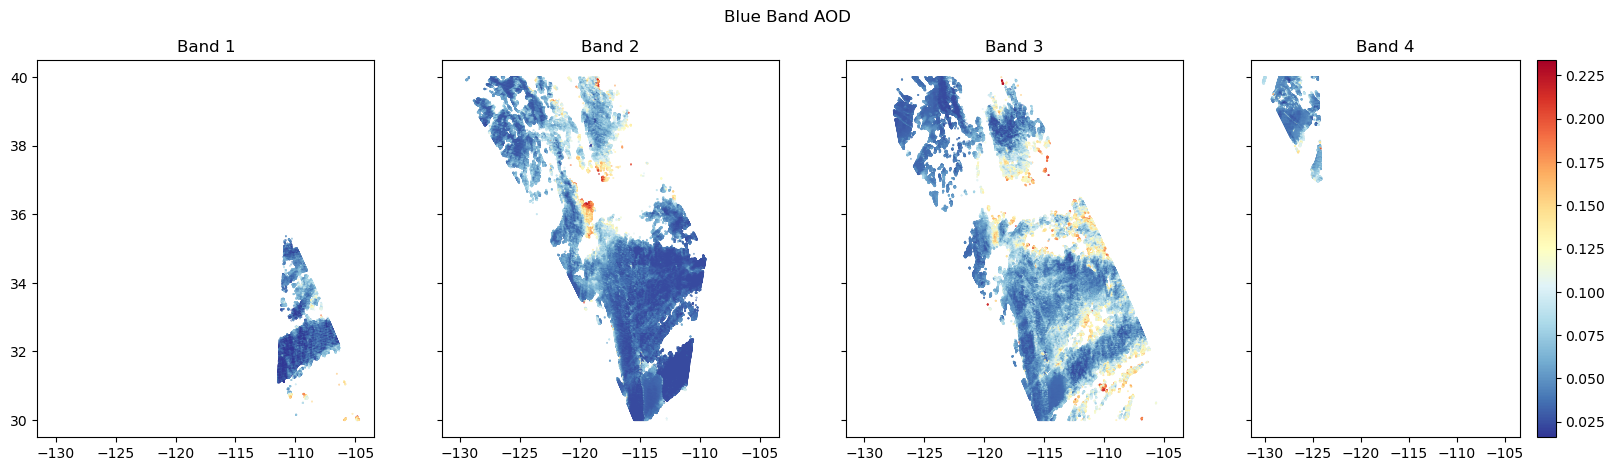

In [40]:
# Plot each orbit individually
plot_gdf(gdf, separate_bands=True)

In [41]:
#Raster based approach

In [42]:
# Identify grid bounds in the sinusoidal projection
x0_s, y0_s = alignment_dict["upper_left"]
x1_s, y1_s = alignment_dict["lower_right"]

# Reproject coordinates bounds to WGS 84
(x0_w, x1_w), (y0_w, y1_w) = transform_arrays(
    [x0_s, x1_s],
    [y0_s, y1_s],
    sinu_crs,
    wgs84_crs
)

In [43]:
def compute_affine_transform(x0, x1, y0, y1, height: int, width: int):
    """Given bounding coordinates and resolution, compute
    the affine transformation.
    
    Args:
        x0 (float): left coordinate.
        x1 (float): right coordinate.
        y0 (float): top coordinate.
        y1 (float): bottom coordinate.
        height (int): image height.
        width (int): image width.

    Returns:
        affine_transform (Affine): Affine transformation.
    """
    affine_transform = rasterio.transform.from_bounds(
        west=x0,
        south=y1,
        east=x1,
        north=y0,
        height=height,
        width=width
    )
    return affine_transform

In [44]:
# Compute the sinusoidal affine transformation
transform_sinu = compute_affine_transform(x0_s, x1_s, y0_s, y1_s, shape[1], shape[2])
transform_sinu

Affine(926.6254330558345, 0.0, -11119505.196667,
       0.0, -926.6254330558334, 4447802.078667)

In [45]:
# Compute WGS 84 affine transform
transform_wgs84 = compute_affine_transform(x0_w, x1_w, y0_w, y1_w, shape[1], shape[2])
transform_wgs84

Affine(0.022181400393890355, 0.0, -130.54072891464722,
       0.0, -0.008333333332587473, 39.99999999641088)

In [46]:
def reproject_data(
    data: np.ma.MaskedArray,
    src_crs: CRS,
    dst_crs: CRS,
    src_transform: Affine,
    dst_transform: Affine,
):
    """Reproject a numpy array from one CRS to another, assuming
    a fill value of nan.
    
    Args:
        data (np.ma.MaskedArray): data as a masked array.
        src_crs (CRS): original coordinate reference system.
        dst_crs (CRS): destination coordinate reference system.
        src_transform (Affine): source affine transformation.
        dst_transform (Affine): destination affine transformation.

    Returns:
        dst_data (np.ma.MaskedArray): reprojected data as a masked array.
    """
    # Initialize array containing nans
    dst_arr = np.empty(data.shape, dtype=np.double)
    dst_arr[:] = np.nan

    # Reproject corrected AOD to WGS 84
    dst_data, dst_transform = reproject(
        source=data.data,
        destination=dst_arr,
        src_transform=src_transform,
        src_crs=src_crs,
        src_nodata=np.nan,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        dst_nodata=np.nan,
        resampling=Resampling.bilinear,
    )
    dst_data = np.ma.masked_array(dst_data, np.isnan(dst_data))
    dst_data.fill_value = np.nan
    return dst_data

In [47]:
# Reproject data to WGS 84
reprojected_data = reproject_data(
    corrected_AOD,
    sinu_crs,
    wgs84_crs,
    transform_sinu,
    transform_wgs84
)

reprojected_data.shape

(4, 1200, 1200)

In [48]:
# We can save our new tif to the "interim" folder
with (INTERIM / la_file.name) as filepath:
    with rasterio.open(
        fp=filepath,
        mode="w+",
        driver="GTiff",
        count=reprojected_data.shape[0],
        height=reprojected_data.shape[1],
        width=reprojected_data.shape[2],
        dtype=str(reprojected_data.dtype),
        crs=wgs84_crs,
        transform=transform_wgs84,
        nodata=reprojected_data.fill_value
    ) as dst:
        dst.write(reprojected_data)
        
dst.shape

(1200, 1200)

In [49]:
# Identify LA granule filepaths and grid cells
maiac_md = maiac_md[maiac_md.location == "la"]

#changed code to access internally saved files
la_fp = []
for i in range(maiac_md.shape[0]):
    la_fp.append(str(maiac_md.iloc[i]['split']) + "/" + str(maiac_md.iloc[i]['product']) + "/" + str(maiac_md.iloc[i]['time_start'].year) + "/" + str(maiac_md.iloc[i].name))
print(len(la_fp))
la_gc = grid_md[grid_md.location == "Los Angeles (SoCAB)"].copy()

# Load training labels
train_labels = pd.read_csv(RAW / "train_labels.csv", parse_dates=["datetime"])
train_labels.rename(columns={"value": "pm25"}, inplace=True)

# Confirm all LA grid cells are in our training labels
assert la_gc.index.isin(train_labels.grid_id).all()

len(la_gc)

1065


14

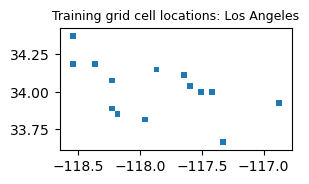

In [50]:
la_polys = gpd.GeoSeries.from_wkt(la_gc.wkt, crs=wgs84_crs) # used for WGS 84
la_polys.name = "geometry"
la_polys_gdf = gpd.GeoDataFrame(la_polys)

la_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Los Angeles", fontsize=9);

In [51]:
xmin, ymin, xmax, ymax = la_polys_gdf.total_bounds
gpd.sjoin(la_polys_gdf, gdf.cx[xmin:xmax, ymin:ymax], how="inner").groupby("grid_id")["value"].mean()

grid_id
3S31A    0.083632
A2FBI    0.081053
DHO4M    0.142227
DJN0F    0.077973
E5P9N    0.102154
FRITQ    0.123091
H96P6    0.132739
PG3MI    0.131395
QJHW4    0.132235
VBLD0    0.134880
WT52R    0.128528
X5DKW    0.162390
ZP1FZ    0.093143
ZZ8JF    0.083133
Name: value, dtype: float64

In [52]:
def create_calibration_dict(data: SDS):
    """Define calibration dictionary given a SDS dataset,
    which contains:
        - name
        - scale factor
        - offset
        - unit
        - fill value
        - valid range
    
    Args:
        data (SDS): dataset in the SDS format.
    
    Returns:
        calibration_dict (Dict): dict of calibration parameters.
    """
    return data.attributes()


def create_alignment_dict(hdf: SD):
    """Define alignment dictionary given a SD data file, 
    which contains:
        - upper left coordinates
        - lower right coordinates
        - coordinate reference system (CRS)
        - CRS parameters
    
    Args:
        hdf (SD): hdf data object
    
    Returns:
        alignment_dict (Dict): dict of alignment parameters.
    """
    group_1 = hdf.attributes()["StructMetadata.0"].split("END_GROUP=GRID_1")[0]
    hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])
    alignment_dict = {
        "upper_left": eval(hdf_metadata["UpperLeftPointMtrs"]),
        "lower_right": eval(hdf_metadata["LowerRightMtrs"]),
        "crs": hdf_metadata["Projection"],
        "crs_params": hdf_metadata["ProjParams"]
    }
    return alignment_dict

In [53]:
def preprocess_maiac_data(
    granule_path: str,
    grid_cell_gdf: gpd.GeoDataFrame,
    dataset_name: str,
    total_bounds: np.ndarray = None
):
    """
    Given a granule s3 path and competition grid cells, 
    create a GDF of each intersecting point and the accompanying
    dataset value (e.g. blue band AOD).
    
    Args:
        granule_path (str): a path to a granule on s3.
        grid_cell_gdf (gpd.GeoDataFrame): GeoDataFrame that contains,
            at a minimum, a `grid_id` and `geometry` column of Polygons.
        dataset_name (str): specific dataset name (e.g. "Optical_Depth_047").
        total_bounds (np.ndarray, optional): If provided, will filter out points that fall
            outside of these bounds. Composed of xmin, ymin, xmax, ymax.    
    Returns:
        GeoDataFrame that contains Points and associated values.
    """
    # Load blue band AOD data
    #s3_path = S3Path(granule_path)
    #print(s3_path)
    #hdf = SD(la_file_path, SDC.READ)
    
    hdf = SD(granule_path, SDC.READ)
    #print(hdf)
    aod = hdf.select(dataset_name)
    shape = aod.info()[2]
    head, tail = os.path.split(granule_path)

    # Calibrate and align data
    calibration_dict = aod.attributes()
    alignment_dict = create_alignment_dict(hdf)
    corrected_AOD = calibrate_data(aod, shape, calibration_dict)
    xv, yv = create_meshgrid(alignment_dict, shape)
    lon, lat = transform_arrays(xv, yv, sinu_crs, wgs84_crs)

    # Save values that align with granules
    granule_gdf = convert_array_to_df(
        corrected_AOD,
        lat,
        lon,
        tail,
        wgs84_crs,
        grid_cell_gdf.total_bounds
    )
    df = gpd.sjoin(grid_cell_gdf, granule_gdf, how="inner")
    
    # Clean up files
    return df.drop(columns="index_right").reset_index()

    
def preprocess_aod_47(granule_paths, grid_cell_gdf, n_jobs=2):
    """
    Given a set of granule s3 paths and competition grid cells, 
    parallelizes creation of GDFs containing AOD 0.47 µm values and points.
    
    Args:
        granule_paths (List): list of paths on s3.
        grid_cell_gdf (gpd.GeoDataFrame): GeoDataFrame that contains,
            at a minimum, a `grid_id` and `geometry` column of Polygons.
        n_jobs (int, Optional): The number of parallel processes. Defaults to 2.
    
    Returns:
        GeoDataFrame that contains Points and associated values for all granules.
    """
    #print(granule_paths)
    args = ((gp, grid_cell_gdf, "Optical_Depth_047") for gp in granule_paths)
    #print(granule_paths)
    results = pqdm(args, preprocess_maiac_data, n_jobs=n_jobs, argument_type="args")
    #print(results)
    return pd.concat(results)

In [54]:
frames = []

print(len(la_fp)) #the total number of iterations

for i in range(len(la_fp)): #this step takes about 35 minutes to run
    print(i) #print current iteration
    la_train_gdf = pd.DataFrame(preprocess_maiac_data(la_fp[i], la_polys_gdf, "Optical_Depth_047"))
    frames.append(la_train_gdf)

la_train_gdf = pd.concat(frames)

#this saves the results to load later
#%store la_train_gdf

1065
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

In [57]:
%store -r la_train_gdf
la_train_gdf

,grid_id,geometry,granule_id,orbit,value
0,3S31A,"POLYGON ((-117.93382 33.79558, -117.93382 33.8...",20180201T191000_maiac_la_0.hdf,2,0.093
1,3S31A,"POLYGON ((-117.93382 33.79558, -117.93382 33.8...",20180201T191000_maiac_la_0.hdf,1,0.074
2,3S31A,"POLYGON ((-117.93382 33.79558, -117.93382 33.8...",20180201T191000_maiac_la_0.hdf,1,0.067
3,3S31A,"POLYGON ((-117.93382 33.79558, -117.93382 33.8...",20180201T191000_maiac_la_0.hdf,2,0.098
4,3S31A,"POLYGON ((-117.93382 33.79558, -117.93382 33.8...",20180201T191000_maiac_la_0.hdf,2,0.094
...,...,...,...,...,...
503,ZZ8JF,"POLYGON ((-117.30500 33.64615, -117.30500 33.6...",20201231T195500_maiac_la_0.hdf,0,0.214
504,ZZ8JF,"POLYGON ((-117.30500 33.64615, -117.30500 33.6...",20201231T195500_maiac_la_0.hdf,3,0.061
505,ZZ8JF,"POLYGON ((-117.30500 33.64615, -117.30500 33.6...",20201231T195500_maiac_la_0.hdf,0,0.225
506,ZZ8JF,"POLYGON ((-117.30500 33.64615, -117.30500 33.6...",20201231T195500_maiac_la_0.hdf,3,0.069


In [58]:
la_train_gdf.shape

(380815, 5)

In [59]:
#simple benchmark model
def calculate_features(
    feature_df: gpd.GeoDataFrame,
    label_df: pd.DataFrame,
    stage: str,
):
    """Given processed AOD data and training labels (train) or 
    submission format (test), return a feature GeoDataFrame that contains
    features for mean, max, and min AOD.
    
    Args:
        feature_df (gpd.GeoDataFrame): GeoDataFrame that contains
            Points and associated values.
        label_df (pd.DataFrame): training labels (train) or
            submission format (test).
        stage (str): "train" or "test".
    
    Returns:
        full_data (gpd.GeoDataFrame): GeoDataFrame that contains `mean_aod`,
            `max_aod`, and `min_aod` for each grid cell and datetime.   
    """
    # Add `day` column to `feature_df` and `label_df`
    feature_df["datetime"] = pd.to_datetime(
        feature_df.granule_id.str.split("_", expand=True)[0],
        format="%Y%m%dT%H:%M:%S",
        utc=True
    )
    feature_df["day"] = feature_df.datetime.dt.date
    label_df["day"] = label_df.datetime.dt.date

    # Calculate average AOD per day/grid cell for which we have feature data
    avg_aod_day = feature_df.groupby(["day", "grid_id"]).agg(
        {"value": ["mean", "min", "max"]}
    )
    avg_aod_day.columns = ["mean_aod", "min_aod", "max_aod"]
    avg_aod_day = avg_aod_day.reset_index()

    # Join labels/submission format with feature data
    how = "inner" if stage == "train" else "left"
    full_data = pd.merge(
        label_df,
        avg_aod_day,
        how=how,
        left_on=["day", "grid_id"],
        right_on=["day", "grid_id"]
    )
    return full_data

In [60]:
full_data = calculate_features(la_train_gdf, train_labels, stage="train")
full_data.head(3)

,datetime,grid_id,pm25,day,mean_aod,min_aod,max_aod
0,2018-02-01 08:00:00+00:00,3S31A,11.4,2018-02-01,0.083632,0.063,0.107
1,2018-02-01 08:00:00+00:00,A2FBI,17.0,2018-02-01,0.081053,0.059,0.106
2,2018-02-01 08:00:00+00:00,DJN0F,11.1,2018-02-01,0.077973,0.036,0.133


In [62]:
# 2020 data will be held out for validation
train = full_data[full_data.datetime.dt.year <= 2019].copy()
test = full_data[full_data.datetime.dt.year > 2019].copy()

In [63]:
# Train model on train set
model = RandomForestRegressor()
model.fit(train[["mean_aod", "min_aod", "max_aod"]], train.pm25)

# Compute R2 using our holdout set
model.score(test[["mean_aod", "min_aod", "max_aod"]], test.pm25)

0.004937596949625367

In [64]:
# Refit model on entire training set
model.fit(full_data[["mean_aod", "min_aod", "max_aod"]], full_data.pm25)

RandomForestRegressor()

In [70]:
# Identify test granule s3 paths
test_md = pm_md[(pm_md["product"] == "maiac") & (pm_md["split"] == "test")]

# Identify test grid cells
submission_format = pd.read_csv(RAW / "submission_format.csv", parse_dates=["datetime"])
test_gc = grid_md[grid_md.index.isin(submission_format.grid_id)]

# Process test data for each location
locations = test_gc.location.unique()
loc_map = {"Delhi": "dl", "Los Angeles (SoCAB)": "la", "Taipei": "tpe"}
loc_dfs = []

for loc in locations:
    print(loc)
    these_md = test_md[test_md.location == loc_map[loc]]
    
    #changed code to access internally saved files
    these_fp = []
    for i in range(these_md.shape[0]):
        these_fp.append(str(these_md.iloc[i]['split']) + "/" + str(these_md.iloc[i]['product']) + "/" + str(these_md.iloc[i]['time_start'].year) + "/" + str(these_md.iloc[i].name))
    
    # Create grid cell GeoDataFrame
    these_grid_cells = test_gc[test_gc.location == loc]
    these_polys = gpd.GeoSeries.from_wkt(these_grid_cells.wkt, crs=wgs84_crs)
    these_polys.name = "geometry"
    this_polys_gdf = gpd.GeoDataFrame(these_polys)

    # Preprocess AOD for test granules
    
    #Skyler code replaces this
    #result = preprocess_aod_47(these_fp, this_polys_gdf)
    frames = []
    print(len(these_fp)) #the total number of iterations
    for i in range(len(these_fp)): #this step takes about 35 minutes to run
        print(i) #print current iteration
        train_gdf = pd.DataFrame(preprocess_maiac_data(these_fp[i], this_polys_gdf, "Optical_Depth_047"))
        frames.append(train_gdf)

    train_gdf = pd.concat(frames)
    
    loc_dfs.append(train_gdf)
    
test_df = pd.concat(loc_dfs)


#%store test_df

Taipei
1222
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
27

231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480


In [71]:
%store -r test_df
test_df.head(3)

,grid_id,geometry,granule_id,orbit,value
0,VR4WG,"POLYGON ((121.52576 25.05906, 121.52576 25.099...",20170107T032000_maiac_tpe_0.hdf,1,0.594
1,VR4WG,"POLYGON ((121.52576 25.05906, 121.52576 25.099...",20170107T032000_maiac_tpe_0.hdf,1,0.594
0,1X116,"POLYGON ((121.52576 24.97766, 121.52576 25.018...",20170110T021000_maiac_tpe_0.hdf,2,0.604


In [72]:
# Prepare AOD features
submission_df = calculate_features(test_df, submission_format, stage="test")

# Impute missing features using training set mean/max/min
submission_df.mean_aod.fillna(la_train_gdf.value.mean(), inplace=True)
submission_df.min_aod.fillna(la_train_gdf.value.min(), inplace=True)
submission_df.max_aod.fillna(la_train_gdf.value.max(), inplace=True)
submission_df.drop(columns=["day"], inplace=True)

# Make predictions using AOD features
submission_df["preds"] = model.predict(submission_df[["mean_aod", "min_aod", "max_aod"]])
submission = submission_df[["datetime", "grid_id", "preds"]].copy()
submission.rename(columns={"preds": "value"}, inplace=True)

# Ensure submission indices match submission format
submission_format.set_index(["datetime", "grid_id"], inplace=True)
submission.set_index(["datetime", "grid_id"], inplace=True)
assert submission_format.index.equals(submission.index)

In [73]:
submission.head(3)

value
datetime                  grid_id           
2017-01-07 16:00:00+00:00 1X116    12.845386
                          9Q6TA    12.845386
                          KW43U    12.845386

In [74]:
submission.describe()

,value
count,13504.000000
mean,18.924434
std,12.206417
min,3.044118
25%,12.845386
50%,12.845386
75%,18.277896
max,84.740645


In [75]:
# Save submission in the correct format
final_submission = pd.read_csv(RAW / "submission_format.csv")
final_submission["value"] = submission.reset_index().value
final_submission.to_csv((INTERIM / "submission.csv"), index=False)